In [2]:
import os
import pickle
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
import tensorboard as tb
from tensorboard.backend.event_processing import event_accumulator
from random import choices
from itertools import combinations

In [3]:
def age_debiasing(predicted_ages, chronological_ages):
    
    predicted_ages = predicted_ages.to_numpy()
    chronological_ages = chronological_ages.to_numpy()
    
    ones = np.ones(len(chronological_ages))
    chronological_ages_squared = np.square(chronological_ages)
    chronological_ages_confounds = np.array([ones, chronological_ages])
    
    ones_predicted = np.ones(len(predicted_ages))
    predicted_ages_squared = np.square(predicted_ages)
    predicted_ages_confounds = np.array([ones_predicted, predicted_ages])
    
    predicted_ages = np.reshape(predicted_ages, (len(predicted_ages), 1) )
    beta = np.dot( np.linalg.pinv(chronological_ages_confounds.T), predicted_ages )

    corrected_predicted_ages = (predicted_ages.flatten() - beta[0])/beta[1]
    
    return corrected_predicted_ages

def age_debiasing(predicted_ages, chronological_ages):
    
    predicted_ages = predicted_ages.to_numpy()
    chronological_ages = chronological_ages.to_numpy()
    
    ones = np.ones(len(chronological_ages))
    chronological_ages_squared = np.square(chronological_ages)
    chronological_ages_confounds = np.array([ones, chronological_ages])
    
    ones_predicted = np.ones(len(predicted_ages))
    predicted_ages_squared = np.square(predicted_ages)
    predicted_ages_confounds = np.array([ones_predicted, predicted_ages])
    
    predicted_ages = np.reshape(predicted_ages, (len(predicted_ages), 1) )
    beta = np.dot( np.linalg.pinv(chronological_ages_confounds.T), predicted_ages )

    corrected_predicted_ages = (predicted_ages.flatten() - beta[0])/beta[1]
    
    return corrected_predicted_ages

def tensorboard_reader(directory, tag='AgeDelta/epoch'):
    """
    Sources: 
    https://stackoverflow.com/questions/41074688/how-do-you-read-tensorboard-files-programmatically
    https://stackoverflow.com/questions/37304461/tensorflow-importing-data-from-a-tensorboard-tfevent-file
    """
    
    for dataset in ['train', 'validation']:
    
        dct = {}
        steps = []
        values = []
    
        if dataset == 'train':
            dir_name = directory + '/train/'
        else:
            dir_name = directory + '/validation/'

        list_of_files = os.listdir(dir_name)

        for file in list_of_files:
            file_name=dir_name+file
#             print(file_name)
            ea = event_accumulator.EventAccumulator(file_name,
              size_guidance={
              event_accumulator.COMPRESSED_HISTOGRAMS: 500,
              event_accumulator.IMAGES: 4,
              event_accumulator.AUDIO: 4,
              event_accumulator.SCALARS: 0,
              event_accumulator.HISTOGRAMS: 1,
          })
            ea.Reload()
#             print(ea.Tags())
            if tag in ea.Tags()['scalars']:
                for e in ea.Scalars(tag):
                    step = e.step
                    value = e.value
                    steps.append(step)
                    values.append(value)

        dct['step'] = steps
        
        if dataset == 'train':
            dct['train'] = values
            dfp = pd.DataFrame.from_dict(dct)
        else:
            dct['validation'] = values
            dfv = pd.DataFrame.from_dict(dct)

    df = pd.merge(dfp, dfv, how='left', on='step')
    df = df.sort_values('step')
    
    return df

def linear_plotter(x, y_train, y_validation, xlabel, ylabel, title, ylim_flag=False, xlim=None):
    
    if isinstance(x, np.ndarray):
        pass
    else:
        x = x.values
        y_train = y_train.values
        y_validation = y_validation.values
    
    plt.figure(figsize=[14.4,7.2])
    plt.plot(x, y_train, label='Train')
    plt.plot(x, y_validation, label='Validation')
    plt.xlabel(xlabel)
    if ylim_flag == True:
        ylim_min = -0.25
        ylim_max = np.max(y_train) + 5
        plt.ylim((ylim_min, ylim_max))
    best_validation = np.min(y_validation)
    best_epoch = x[np.where(y_validation == np.min(y_validation))[0][0]]
    best_train = y_train[np.where(y_validation == np.min(y_validation))[0][0]]
    gap = best_train - best_validation
    print(best_epoch, best_validation)
    print(-gap)
    plt.scatter(x=best_epoch, y=best_validation, s=100, marker='*', color='red', label='Selected Best Epoch')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    if xlim is not None:
        plt.xlim(xlim)
    plt.show()
    
def linear_plotter_comparison(Xs, Ys, Labels,
                              xlabel, ylabel, title, ylim_flag=False):
    
    plt.figure(figsize=[7,5])
    for idx, x in enumerate(Xs):
        plt.plot(x, Ys[idx], label=Labels[idx])
    plt.xlabel(xlabel)
    if ylim_flag == True:
        ylim_min = -0.25
        y_max = [np.max(Ys[idx]) for idx in range(len(Ys))]
        ylim_max = min(y_max)
        plt.ylim((ylim_min, ylim_max))
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()
    
def plot_everything(network='49', ylim2=[2.175, 2.45], control=False):
    dfs = []
    names = []
    range_points = [1,2,3]
#     network = '49'
    preambul = 'MM'
    if control == True:
        preambul = 'AM'
        range_points = [10,11,12]

    tag = 'AgeDelta/epoch'
    for i in range_points:
        name = preambul + str(int(i)) + '-' + network
        directory = '../logs/' + name
        df = tensorboard_reader(directory=directory, tag=tag)
        dfs.append(df)
        names.append(name)

    dfs2 = []
    names2 = []
    range_points = [1,2,3]
#     network = '49'

    tag2 = 'LearningRate/iteration'
    for i in range_points:
        name2 = preambul + str(int(i)) + '-' + network
        directory2 = '../logs/' + name
    #     if os.path.isdir(directory):
        df2 = tensorboard_reader(directory=directory2, tag=tag2)
        dfs2.append(df2)
        names2.append(name2)

    for i, df in enumerate(dfs):
        name = names[i]
        df = df.dropna(axis=0)
        linear_plotter(x=df.step, y_train=df.train, y_validation=df.validation, 
                       xlabel='Epochs', ylabel=tag, title=name, xlim=[-2, 300])

    Xs = [dfs[i].step.values for i in range(len(dfs))]
    Ys = [dfs[i].validation.values for i in range(len(dfs))]
    Labels = [preambul + str(int(i)) + '-' + network for i in range_points]
    xlabel='Epochs'
    ylabel='AgeDelta/epoch'

    plt.figure(figsize=[14.4,7.2])
    for idx, x in enumerate(Xs):
        y = Ys[idx]
        x = np.delete(x, np.argwhere(np.isnan(y)))
        y = np.delete(y, np.argwhere(np.isnan(y)))
        plt.plot(x, y, label=Labels[idx], alpha=0.3)
        best_validation = np.min(y)
        best_epoch = x[np.where(y == np.min(y))[0][0]]
        label = 'Selected Best Epoch for ' + Labels[idx]
        if idx < 3:
            plt.scatter(x=best_epoch, y=best_validation, s=150, marker='*', label=label)
        else:
            plt.scatter(x=best_epoch, y=best_validation, s=150, marker='o', label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.ylim(ylim2)
    plt.xlim([-1,300])
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')

#     for idx in range(len(dfs2)):
#         dfs2[idx].step = dfs2[idx].step / (dfs2[idx].step.max() / dfs[idx].step.max())

#     ncols=2
#     nrows=1
#     sz=7.2
#     title_font_size=22
#     ticks_font_size=18
#     legend_font = 18

#     for idx in range(len(dfs)):

#         fig, axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=(ncols*sz,nrows*sz))

#         axes = axes.ravel()

#         axes[0] = plt.subplot()
#         ax2 = axes[0].twinx()
#         l1, = axes[0].plot(dfs[idx].step, dfs[idx].validation, color='tab:orange')
#         l2, = ax2.plot(dfs2[idx].step, dfs2[idx].train, linestyle='dotted', color='b')

#         best_validation = np.min(dfs[idx].validation.values)
#         best_epoch = dfs[idx].step.values[np.where(dfs[idx].validation.values == best_validation)[0][0]]
#         l3 = axes[0].scatter(x=best_epoch, y=best_validation, s=100, marker='*', color='red')


#         plt.legend([l1, l2, l3], ['Val Curve', 'LR', 'Selected Best Epoch'])




#         axes[0].set_ylabel('Age Delta')
#         ax2.set_ylabel('Learning Rate')
#         axes[0].set_xlabel('Training Epochs')
#         ax2.grid(linestyle='--')

#         axes[0].set_xlim([-2, 300])

In [4]:
!ls '../../agemapper/'

Analsysis Female New
Analysis - SFCN vs HGL
Analysis Male New
Analysis Project 2
Analysis_data
MRI-based age prediction using hidden Markov models - ScienceDirect.html
additional_codes
data_examples
figures
logs
multi-age-mapper
predictions
untitled folder


In [5]:
df = pd.read_pickle('../../agemapper/Analsysis Female New/female_test.pkl')
df_test = {}
df_test['Unnamed: 0'] = df.iloc[0].dataframe['Unnamed: 0'].to_list()
for idx in range(len(df)):
    name = df.iloc[idx].modality
    data = df.iloc[idx].dataframe.mean_output_age.to_list()
    df_test[name] = data
    
df_test = pd.DataFrame.from_dict(df_test)
df_test['target_age'] = df.iloc[0].dataframe.target_age.to_list()

df_testA, df_testB = train_test_split(df_test, test_size=0.5, random_state=1)
subjectsA = df_testA['Unnamed: 0'].to_list()
subjectsB = df_testB['Unnamed: 0'].to_list()
del df_testA, df_testB, df

In [6]:

net1 = "1" # T1NL
net2 = '2' # T2NL
net3 = '3' # FA
net4 = "4" # MD
net5 = '8' # rsfMRI 0
net6 = '9' # SWI
net7 = "10" # tfMRI 1
net8 = '12' # dmri tracts
net9 = '14' # MO
net10 = "6" # TBSS ISOVF
net11 = '15' # L2
net12 = '7' # rsfMRI 2
net13 = "16" # rsfMRI 10
net14 = '17' # rsfMRI 5
net15 = '18' # rsfMRI 21
net16 = "13" # T2 Lessions
net17 = '5' # TBSS FA
net18 = '19' # TBSS L3

# net19 = '11' # tfMRI 5

dfs = [
    net1,
    net2,
    net3,
    net4,
    net5,
    net6,
    net7,
    net8,
    net9,
    net10,
    net11,
    net12,
    net13,
    net14,
    net15,
    net16,
    net17,
    net18,
#     net19
]

names = [

    'T1_nonlinear',           #1
    'T2_nonlinear',           #2
    'tbss_FA',                #3
    'tbss_MD',                #4
    'rsfmri_0',               #5
    'swi',                    #6
    'tfmri_1',                #7
    'tracts',                 #8
    'tbss_MO',                #9
    'tbss_ISOVF_s',           #10
    'tbss_L2',                #11
    'rsfmri_2',               #12
    'rsfmri_10',              #13
    'rsfmri_5',               #14
    'rsfmri_21',              #15
    'T2_lessions',            #16
    'tbss_FA_s',              #17
    'tbss_L3_s',              #18
#     'tfmri_5',                #19
    
]
    

dfs1, dfs2, dfs3 = [], [], []
dfs4, dfs5, dfs6 = [], [], []
dfs7, dfs8, dfs9 = [], [], []

dfs1 = dfs.copy()
dfs2 = dfs.copy()
dfs3 = dfs.copy()
dfs4 = dfs.copy()
dfs5 = dfs.copy()
dfs6 = dfs.copy()
dfs7 = dfs.copy()
dfs8 = dfs.copy()
dfs9 = dfs.copy()


for idx in range(len(dfs)):
    
    dfs1[idx] = '../predictions/SN1-' + dfs1[idx] + '_predictions/output_statistics_test.csv'
    dfs2[idx] = '../predictions/SN2-' + dfs2[idx] + '_predictions/output_statistics_test.csv'
    dfs3[idx] = '../predictions/SN3-' + dfs3[idx] + '_predictions/output_statistics_test.csv'
    dfs4[idx] = '../predictions/SN4-' + dfs4[idx] + '_predictions/output_statistics_test.csv'
    dfs5[idx] = '../predictions/SN5-' + dfs5[idx] + '_predictions/output_statistics_test.csv'
    dfs6[idx] = '../predictions/SN6-' + dfs6[idx] + '_predictions/output_statistics_test.csv'
    dfs7[idx] = '../predictions/SN7-' + dfs7[idx] + '_predictions/output_statistics_test.csv'
    dfs8[idx] = '../predictions/SN8-' + dfs8[idx] + '_predictions/output_statistics_test.csv'
    dfs9[idx] = '../predictions/SN9-' + dfs9[idx] + '_predictions/output_statistics_test.csv'

    
for idx in range(len(dfs)):
    dfs1[idx] = pd.read_csv(dfs1[idx])
    dfs2[idx] = pd.read_csv(dfs2[idx])
    dfs3[idx] = pd.read_csv(dfs3[idx])
    dfs4[idx] = pd.read_csv(dfs4[idx])
    dfs5[idx] = pd.read_csv(dfs5[idx])
    dfs6[idx] = pd.read_csv(dfs6[idx])
    dfs7[idx] = pd.read_csv(dfs7[idx])
    dfs8[idx] = pd.read_csv(dfs8[idx])
    dfs9[idx] = pd.read_csv(dfs9[idx])

subjects = subjectsA

for idx in range(len(dfs)):
    for subj in dfs1[idx]['Unnamed: 0'].to_list():
        if subj not in subjects:
            dfs1[idx] = dfs1[idx].drop(dfs1[idx][dfs1[idx]['Unnamed: 0'] == subj].index)
            dfs2[idx] = dfs2[idx].drop(dfs2[idx][dfs2[idx]['Unnamed: 0'] == subj].index)
            dfs3[idx] = dfs3[idx].drop(dfs3[idx][dfs3[idx]['Unnamed: 0'] == subj].index)
            dfs4[idx] = dfs4[idx].drop(dfs4[idx][dfs4[idx]['Unnamed: 0'] == subj].index)
            dfs5[idx] = dfs5[idx].drop(dfs5[idx][dfs5[idx]['Unnamed: 0'] == subj].index)
            dfs6[idx] = dfs6[idx].drop(dfs6[idx][dfs6[idx]['Unnamed: 0'] == subj].index)
            dfs7[idx] = dfs7[idx].drop(dfs7[idx][dfs7[idx]['Unnamed: 0'] == subj].index)
            dfs8[idx] = dfs8[idx].drop(dfs8[idx][dfs8[idx]['Unnamed: 0'] == subj].index)
            dfs9[idx] = dfs9[idx].drop(dfs9[idx][dfs9[idx]['Unnamed: 0'] == subj].index)
    
    
for idx in range(len(dfs)):
    dfs[idx] = pd.merge(dfs1[idx], dfs2[idx], on='Unnamed: 0', how='inner')
    dfs[idx] = pd.merge(dfs[idx], dfs3[idx], on='Unnamed: 0', how='inner')
    
    dfs[idx].rename({
        'target_age_x': 'target_age_original',
        'output_age_x': 'output_age_1',
        'age_delta_x': 'age_delta_1',
        'loss_x': 'loss_1',
        'target_age_y': 'target_age_2',
        'output_age_y': 'output_age_2',
        'age_delta_y': 'age_delta_2',
        'loss_y': 'loss_2',
        'target_age': 'target_age_3',
        'output_age': 'output_age_3',
        'age_delta': 'age_delta_3',
        'loss': 'loss_3',
    }, axis=1, inplace=True)
    
    dfs[idx].drop(['target_age_2', 'target_age_3'], axis=1, inplace=True)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs4[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_4',
        'age_delta': 'age_delta_4',
        'loss': 'loss_4',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs5[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_5',
        'age_delta': 'age_delta_5',
        'loss': 'loss_5',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs6[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_6',
        'age_delta': 'age_delta_6',
        'loss': 'loss_6',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
      
    
    dfs[idx] = pd.merge(dfs[idx], dfs7[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_7',
        'age_delta': 'age_delta_7',
        'loss': 'loss_7',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs8[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_8',
        'age_delta': 'age_delta_8',
        'loss': 'loss_8',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs9[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_9',
        'age_delta': 'age_delta_9',
        'loss': 'loss_9',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    dfs[idx].rename({
        'target_age_original': 'target_age',
    }, axis=1, inplace=True)
    
    dfs[idx]['mean_output_age'] = dfs[idx][['output_age_1', 'output_age_2', 'output_age_3',
                                           'output_age_4', 'output_age_5', 'output_age_6',
                                           'output_age_7', 'output_age_8', 'output_age_9',
                                           ]].mean(axis=1)
    dfs[idx]['mean_age_delta'] = dfs[idx]['mean_output_age'] - dfs[idx]['target_age']
    
for idx in range(len(dfs)):    
    dfs[idx]['output_age_decon'] = age_debiasing(dfs[idx].mean_output_age, dfs[idx].target_age) 
    dfs[idx]['age_delta_decon'] = dfs[idx].output_age_decon - dfs[idx].target_age

d = {'modality':names, 'dataframe':dfs}
df = pd.DataFrame(data=d)
df.to_pickle('female_test_testA_convergence9.pkl', protocol = 4)

In [7]:

net1 = "1" # T1NL
net2 = '2' # T2NL
net3 = '3' # FA
net4 = "4" # MD
net5 = '8' # rsfMRI 0
net6 = '9' # SWI
net7 = "10" # tfMRI 1
net8 = '12' # dmri tracts
net9 = '14' # MO
net10 = "6" # TBSS ISOVF
net11 = '15' # L2
net12 = '7' # rsfMRI 2
net13 = "16" # rsfMRI 10
net14 = '17' # rsfMRI 5
net15 = '18' # rsfMRI 21
net16 = "13" # T2 Lessions
net17 = '5' # TBSS FA
net18 = '19' # TBSS L3

# net19 = '11' # tfMRI 5

dfs = [
    net1,
    net2,
    net3,
    net4,
    net5,
    net6,
    net7,
    net8,
    net9,
    net10,
    net11,
    net12,
    net13,
    net14,
    net15,
    net16,
    net17,
    net18,
#     net19
]

names = [

    'T1_nonlinear',           #1
    'T2_nonlinear',           #2
    'tbss_FA',                #3
    'tbss_MD',                #4
    'rsfmri_0',               #5
    'swi',                    #6
    'tfmri_1',                #7
    'tracts',                 #8
    'tbss_MO',                #9
    'tbss_ISOVF_s',           #10
    'tbss_L2',                #11
    'rsfmri_2',               #12
    'rsfmri_10',              #13
    'rsfmri_5',               #14
    'rsfmri_21',              #15
    'T2_lessions',            #16
    'tbss_FA_s',              #17
    'tbss_L3_s',              #18
#     'tfmri_5',                #19
    
]
    
    
dfs1, dfs2, dfs3 = [], [], []
dfs4, dfs5, dfs6 = [], [], []
dfs7, dfs8, dfs9 = [], [], []

dfs1 = dfs.copy()
dfs2 = dfs.copy()
dfs3 = dfs.copy()
dfs4 = dfs.copy()
dfs5 = dfs.copy()
dfs6 = dfs.copy()
dfs7 = dfs.copy()
dfs8 = dfs.copy()
dfs9 = dfs.copy()


for idx in range(len(dfs)):
    
    dfs1[idx] = '../predictions/SN1-' + dfs1[idx] + '_predictions/output_statistics_test.csv'
    dfs2[idx] = '../predictions/SN2-' + dfs2[idx] + '_predictions/output_statistics_test.csv'
    dfs3[idx] = '../predictions/SN3-' + dfs3[idx] + '_predictions/output_statistics_test.csv'
    dfs4[idx] = '../predictions/SN4-' + dfs4[idx] + '_predictions/output_statistics_test.csv'
    dfs5[idx] = '../predictions/SN5-' + dfs5[idx] + '_predictions/output_statistics_test.csv'
    dfs6[idx] = '../predictions/SN6-' + dfs6[idx] + '_predictions/output_statistics_test.csv'
    dfs7[idx] = '../predictions/SN7-' + dfs7[idx] + '_predictions/output_statistics_test.csv'
    dfs8[idx] = '../predictions/SN8-' + dfs8[idx] + '_predictions/output_statistics_test.csv'
    dfs9[idx] = '../predictions/SN9-' + dfs9[idx] + '_predictions/output_statistics_test.csv'

    
for idx in range(len(dfs)):
    dfs1[idx] = pd.read_csv(dfs1[idx])
    dfs2[idx] = pd.read_csv(dfs2[idx])
    dfs3[idx] = pd.read_csv(dfs3[idx])
    dfs4[idx] = pd.read_csv(dfs4[idx])
    dfs5[idx] = pd.read_csv(dfs5[idx])
    dfs6[idx] = pd.read_csv(dfs6[idx])
    dfs7[idx] = pd.read_csv(dfs7[idx])
    dfs8[idx] = pd.read_csv(dfs8[idx])
    dfs9[idx] = pd.read_csv(dfs9[idx])

subjects = subjectsB

for idx in range(len(dfs)):
    for subj in dfs1[idx]['Unnamed: 0'].to_list():
        if subj not in subjects:
            dfs1[idx] = dfs1[idx].drop(dfs1[idx][dfs1[idx]['Unnamed: 0'] == subj].index)
            dfs2[idx] = dfs2[idx].drop(dfs2[idx][dfs2[idx]['Unnamed: 0'] == subj].index)
            dfs3[idx] = dfs3[idx].drop(dfs3[idx][dfs3[idx]['Unnamed: 0'] == subj].index)
            dfs4[idx] = dfs4[idx].drop(dfs4[idx][dfs4[idx]['Unnamed: 0'] == subj].index)
            dfs5[idx] = dfs5[idx].drop(dfs5[idx][dfs5[idx]['Unnamed: 0'] == subj].index)
            dfs6[idx] = dfs6[idx].drop(dfs6[idx][dfs6[idx]['Unnamed: 0'] == subj].index)
            dfs7[idx] = dfs7[idx].drop(dfs7[idx][dfs7[idx]['Unnamed: 0'] == subj].index)
            dfs8[idx] = dfs8[idx].drop(dfs8[idx][dfs8[idx]['Unnamed: 0'] == subj].index)
            dfs9[idx] = dfs9[idx].drop(dfs9[idx][dfs9[idx]['Unnamed: 0'] == subj].index)
    
    
for idx in range(len(dfs)):
    dfs[idx] = pd.merge(dfs1[idx], dfs2[idx], on='Unnamed: 0', how='inner')
    dfs[idx] = pd.merge(dfs[idx], dfs3[idx], on='Unnamed: 0', how='inner')
    
    dfs[idx].rename({
        'target_age_x': 'target_age_original',
        'output_age_x': 'output_age_1',
        'age_delta_x': 'age_delta_1',
        'loss_x': 'loss_1',
        'target_age_y': 'target_age_2',
        'output_age_y': 'output_age_2',
        'age_delta_y': 'age_delta_2',
        'loss_y': 'loss_2',
        'target_age': 'target_age_3',
        'output_age': 'output_age_3',
        'age_delta': 'age_delta_3',
        'loss': 'loss_3',
    }, axis=1, inplace=True)
    
    dfs[idx].drop(['target_age_2', 'target_age_3'], axis=1, inplace=True)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs4[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_4',
        'age_delta': 'age_delta_4',
        'loss': 'loss_4',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs5[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_5',
        'age_delta': 'age_delta_5',
        'loss': 'loss_5',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs6[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_6',
        'age_delta': 'age_delta_6',
        'loss': 'loss_6',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
      
    
    dfs[idx] = pd.merge(dfs[idx], dfs7[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_7',
        'age_delta': 'age_delta_7',
        'loss': 'loss_7',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs8[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_8',
        'age_delta': 'age_delta_8',
        'loss': 'loss_8',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs9[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_9',
        'age_delta': 'age_delta_9',
        'loss': 'loss_9',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    dfs[idx].rename({
        'target_age_original': 'target_age',
    }, axis=1, inplace=True)
    
    dfs[idx]['mean_output_age'] = dfs[idx][['output_age_1', 'output_age_2', 'output_age_3',
                                           'output_age_4', 'output_age_5', 'output_age_6',
                                           'output_age_7', 'output_age_8', 'output_age_9',
                                           ]].mean(axis=1)
    dfs[idx]['mean_age_delta'] = dfs[idx]['mean_output_age'] - dfs[idx]['target_age']
    
for idx in range(len(dfs)):    
    dfs[idx]['output_age_decon'] = age_debiasing(dfs[idx].mean_output_age, dfs[idx].target_age) 
    dfs[idx]['age_delta_decon'] = dfs[idx].output_age_decon - dfs[idx].target_age


print("{:15} : {:7}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  |  ".format(
    'Modality', 'Run1', "Run2", "Run3", 'Run4', "Run5", "Run6", 'Run7', "Run8", "Run9",
    "MAE"))
print('-----------------------------------------------------------------------------------------------')

for idx in range(len(dfs)):
#     _, dfs[idx] = train_test_split(dfs[idx], test_size=0.5, random_state=1)
    print("{:15} : {:7.3f}  |  {:.3f} |  {:.3f} |  {:.3f}   |  {:.3f} |  {:.3f} |  {:.3f} |  {:.3f} |  {:.3f} |  {:.3f}   ".format(
        names[idx],
        np.abs(dfs[idx].age_delta_1).mean(), 
        np.abs(dfs[idx].age_delta_2).mean(),
        np.abs(dfs[idx].age_delta_3).mean(),
        np.abs(dfs[idx].age_delta_4).mean(), 
        np.abs(dfs[idx].age_delta_5).mean(),
        np.abs(dfs[idx].age_delta_6).mean(),
        np.abs(dfs[idx].age_delta_7).mean(), 
        np.abs(dfs[idx].age_delta_8).mean(),
        np.abs(dfs[idx].age_delta_9).mean(),

        np.abs(dfs[idx].mean_age_delta).mean(),
    )
         )
    
print('\n')      

print("{:15} : {:5}  |  {:5} |  {:8} |  {:13}  ".format('Modality', 'MAE', "MAE DEB", "MSE", "RMSE"))
print('-----------------------------------------------------------------------------------------------')

for idx in range(len(dfs)):
    
#     _, dfs[idx]s = train_test_split(dfs[idx], test_size=0.5, random_state=1)
    
    print("{:15} :  {:.3f} |   {:.3f}  |   {:.3f}   |   {:.3f}  ".format(
        names[idx],
        np.abs(dfs[idx].mean_age_delta).mean(), 
        np.abs(dfs[idx].age_delta_decon).mean(),
        np.square(np.subtract(dfs[idx].target_age, dfs[idx].mean_output_age)).mean(),
        np.sqrt(np.square(np.subtract(dfs[idx].target_age, dfs[idx].mean_output_age)).mean())
    )
         )

# Modality      : MAE     | MEAN DECONF | CORR (R)   | MAE weighted
# ----------------------------------------------------------------------------------------------------------
# T1 Nonlinear  :  2.242  |      2.445  |     0.922  |  0.060 
# T2 Nonlinear  :  2.189  |      2.360  |     0.926  |  0.059 
# FA            :  2.668  |      3.014  |     0.887  |  0.072 
# MD            :  2.887  |      3.302  |     0.868  |  0.078 
# rsfMRI-0      :  4.173  |      5.738  |     0.702  |  0.112 
# SWI           :  3.054  |      3.628  |     0.847  |  0.082 
# tfMRI-1       :  3.444  |      4.274  |     0.805  |  0.093 
# Summed Tracts :  3.177  |      3.705  |     0.839  |  0.086 
# MO            :  2.953  |      3.431  |     0.860  |  0.080 
# TBSS ISOVF    :  3.331  |      4.025  |     0.823  |  0.090 
# L2            :  2.844  |      3.261  |     0.872  |  0.077 
# rsfMRI-2      :  4.322  |      6.253  |     0.678  |  0.116 
# rsfMRI-10     :  4.357  |      6.339  |     0.667  |  0.117 
# rsfMRI-5      :  4.285  |      6.155  |     0.676  |  0.115 
# rsfMRI-21     :  4.233  |      6.023  |     0.691  |  0.114 
# T2 Lessions   :  3.965  |      5.550  |     0.731  |  0.107 
# TBSS FA       :  2.939  |      3.435  |     0.862  |  0.079 
# TBSS L3       :  3.108  |      3.677  |     0.843  |  0.084 


Modality        : Run1     |  Run2  |  Run3  |  Run4  |  Run5  |  Run6  |  Run7  |  Run8  |  Run9  |  MAE  |  
-----------------------------------------------------------------------------------------------
T1_nonlinear    :   2.527  |  2.507 |  2.504 |  2.475   |  2.468 |  2.479 |  2.539 |  2.536 |  2.484 |  2.366   
T2_nonlinear    :   2.344  |  2.375 |  2.342 |  2.360   |  2.355 |  2.341 |  2.336 |  2.340 |  2.365 |  2.222   
tbss_FA         :   2.880  |  2.822 |  2.773 |  2.872   |  2.832 |  2.830 |  2.828 |  2.812 |  2.864 |  2.680   
tbss_MD         :   3.029  |  3.020 |  3.002 |  2.943   |  2.941 |  2.909 |  2.883 |  2.968 |  2.970 |  2.767   
rsfmri_0        :   4.968  |  5.007 |  4.808 |  4.938   |  4.966 |  5.058 |  5.011 |  4.954 |  4.982 |  4.846   
swi             :   3.276  |  3.110 |  3.270 |  3.221   |  3.250 |  3.167 |  3.276 |  3.216 |  3.307 |  3.034   
tfmri_1         :   4.070  |  4.113 |  4.074 |  4.038   |  4.099 |  4.029 |  4.135 |  4.079 |  4.113 |  3.812   
tr

In [8]:
mae_weighting = 37.137671232876755

modality_names = [
    'T1 Nonlinear', 'T2 Nonlinear', 'FA', 'MD', 'rsfMRI-0', 'SWI', 'tfMRI-1', 'Summed Tracts', 'MO',
    'TBSS ISOVF', 'L2', 'rsfMRI-2', 'rsfMRI-10', 'rsfMRI-5', 'rsfMRI-21', 'T2 Lessions', 'TBSS FA', 'TBSS L3'
]



from sklearn.model_selection import train_test_split

print("{:13} : {:7} | {:7} | {:10} | {:10}".format(
    'Modality', "MAE", "MEAN DECONF", "CORR (R)", "MAE weighted"  ) )
print('----------------------------------------------------------------------------------------------------------')

for idx in range(len(dfs)):

    _, df_testBs = train_test_split(dfs[idx], test_size=0.5, random_state=1)
    
    print("{:13} : {:6.3f}  |  {:9.3f}  |  {:8.3f}  |  {:.3f} ".format(
        modality_names[idx],
        np.abs(dfs[idx].mean_age_delta).mean(),
        np.abs(dfs[idx].age_delta_decon).mean(),
        pearsonr(dfs[idx].target_age, dfs[idx].mean_output_age)[0],
        np.abs(dfs[idx].mean_age_delta).mean() / mae_weighting,
    )
         )

Modality      : MAE     | MEAN DECONF | CORR (R)   | MAE weighted
----------------------------------------------------------------------------------------------------------
T1 Nonlinear  :  2.366  |      2.589  |     0.914  |  0.064 
T2 Nonlinear  :  2.222  |      2.397  |     0.924  |  0.060 
FA            :  2.680  |      3.012  |     0.887  |  0.072 
MD            :  2.767  |      3.156  |     0.879  |  0.074 
rsfMRI-0      :  4.846  |      8.244  |     0.576  |  0.130 
SWI           :  3.034  |      3.609  |     0.851  |  0.082 
tfMRI-1       :  3.812  |      5.023  |     0.758  |  0.103 
Summed Tracts :  3.236  |      3.954  |     0.827  |  0.087 
MO            :  3.022  |      3.571  |     0.852  |  0.081 
TBSS ISOVF    :  3.384  |      4.211  |     0.811  |  0.091 
L2            :  2.787  |      3.222  |     0.876  |  0.075 
rsfMRI-2      :  4.856  |      8.335  |     0.575  |  0.131 
rsfMRI-10     :  4.832  |      8.499  |     0.566  |  0.130 
rsfMRI-5      :  4.876  |      8.4

In [39]:
# Modality        : Run1     |  Run2  |  Run3  |  Run4  |  Run5  |  Run6  |  Run7  |  Run8  |  Run9  |  MAE  |  
# -----------------------------------------------------------------------------------------------
# T1_nonlinear    :   2.490  |  2.483 |  2.382 |  2.476   |  2.467 |  2.504 |  2.487 |  2.439 |  2.399 |  2.190   
# T2_nonlinear    :   2.330  |  2.361 |  2.314 |  2.349   |  2.327 |  2.323 |  2.297 |  2.316 |  2.356 |  2.086   
# tbss_FA         :   2.891  |  2.906 |  2.802 |  2.803   |  2.909 |  2.819 |  2.839 |  2.887 |  2.865 |  2.587   
# tbss_MD         :   3.082  |  3.059 |  2.980 |  3.038   |  3.084 |  3.009 |  3.078 |  3.059 |  2.948 |  2.804   
# rsfmri_0        :   4.397  |  4.485 |  4.435 |  4.471   |  4.545 |  4.476 |  4.451 |  4.478 |  4.406 |  4.220   
# swi             :   3.343  |  3.142 |  3.273 |  3.333   |  3.277 |  3.329 |  3.226 |  3.168 |  3.169 |  2.939   
# tfmri_1         :   3.802  |  3.834 |  3.764 |  3.703   |  3.691 |  3.742 |  3.746 |  3.742 |  3.810 |  3.407   
# tracts          :   3.357  |  3.309 |  3.313 |  3.319   |  3.292 |  3.271 |  3.395 |  3.376 |  3.346 |  3.070   
# tbss_MO         :   3.160  |  3.140 |  3.060 |  3.169   |  3.098 |  3.132 |  3.164 |  3.174 |  3.066 |  2.873   
# tbss_ISOVF_s    :   3.490  |  3.478 |  3.587 |  3.421   |  3.431 |  3.494 |  3.505 |  3.479 |  3.693 |  3.286   
# tbss_L2         :   3.052  |  2.984 |  2.992 |  2.992   |  2.977 |  2.954 |  3.038 |  3.132 |  3.024 |  2.806   
# rsfmri_2        :   4.399  |  4.404 |  4.498 |  4.464   |  4.547 |  4.643 |  4.377 |  4.612 |  4.426 |  4.159   
# rsfmri_10       :   4.714  |  4.539 |  4.479 |  4.515   |  4.477 |  4.560 |  4.506 |  4.553 |  4.512 |  4.243   
# rsfmri_5        :   4.408  |  4.390 |  4.315 |  4.291   |  4.392 |  4.376 |  4.405 |  4.424 |  4.414 |  4.160   
# rsfmri_15       :   4.529  |  4.398 |  4.515 |  4.465   |  4.244 |  4.366 |  4.303 |  4.340 |  4.424 |  4.060   
# T2_lessions     :   4.080  |  4.266 |  4.113 |  4.069   |  4.038 |  4.014 |  4.023 |  4.145 |  4.074 |  3.936   
# tbss_FA_s       :   3.084  |  3.175 |  3.049 |  2.992   |  3.080 |  3.102 |  3.074 |  3.032 |  3.156 |  2.903   
# tbss_L3_s       :   3.380  |  3.345 |  3.281 |  3.404   |  3.266 |  3.294 |  3.258 |  3.312 |  3.317 |  3.132   


# Modality        : MAE    |  MAE DEB |  MSE      |  RMSE           
# -----------------------------------------------------------------------------------------------
# T1_nonlinear    :  2.190 |   2.368  |   7.640   |   2.764  
# T2_nonlinear    :  2.086 |   2.221  |   6.906   |   2.628  
# tbss_FA         :  2.587 |   2.884  |   10.540   |   3.247  
# tbss_MD         :  2.804 |   3.199  |   12.401   |   3.521  
# rsfmri_0        :  4.220 |   5.917  |   27.221   |   5.217  
# swi             :  2.939 |   3.415  |   13.639   |   3.693  
# tfmri_1         :  3.407 |   4.184  |   18.128   |   4.258  
# tracts          :  3.070 |   3.623  |   15.054   |   3.880  
# tbss_MO         :  2.873 |   3.275  |   12.985   |   3.603  
# tbss_ISOVF_s    :  3.286 |   3.962  |   16.712   |   4.088  
# tbss_L2         :  2.806 |   3.173  |   12.286   |   3.505  
# rsfmri_2        :  4.159 |   5.913  |   26.715   |   5.169  
# rsfmri_10       :  4.243 |   6.070  |   27.944   |   5.286  
# rsfmri_5        :  4.160 |   5.893  |   27.115   |   5.207  
# rsfmri_21       :  4.060 |   5.649  |   25.904   |   5.090  
# T2_lessions     :  3.936 |   5.423  |   24.556   |   4.955  
# tbss_FA_s       :  2.903 |   3.384  |   13.277   |   3.644  
# tbss_L3_s       :  3.132 |   3.719  |   15.513   |   3.939  

In [40]:
d = {'modality':names, 'dataframe':dfs}
df = pd.DataFrame(data=d)
df.to_pickle('female_test_testB_convergence9.pkl', protocol = 4)

In [41]:
def convergencePlots(dfs, idx, names):
    MAEs2 = [np.abs(dfs[idx].age_delta_1).mean(), 
            np.abs(dfs[idx].age_delta_2).mean(),
            np.abs(dfs[idx].age_delta_3).mean(),
            np.abs(dfs[idx].age_delta_4).mean(), 
            np.abs(dfs[idx].age_delta_5).mean(),
            np.abs(dfs[idx].age_delta_6).mean(),
            np.abs(dfs[idx].age_delta_7).mean(), 
            np.abs(dfs[idx].age_delta_8).mean(),
            np.abs(dfs[idx].age_delta_9).mean(),
        ]
    MAEsSingle = MAEs2
    
    MAEs = []
    dfs = dfs[idx]

    nets = 0
    maePaths = []
    for col in dfs.columns.values:
        if 'output_age_' in col:
            maePaths.append(col)
            nets += 1

    if 'output_age_decon' in maePaths:
        maePaths.remove('output_age_decon')
        nets -= 1

    maePaths2 = []
    for path in maePaths:
        maePaths2.append(path)
        mean_output_age = dfs[maePaths2].mean(axis=1).to_numpy()
        mean_age_delta = mean_output_age - dfs['target_age'].to_numpy()
        mae = np.abs(mean_age_delta).mean()
        MAEs.append(mae)

    print('% Convergece MAEs')
    for i in np.arange(0, nets, 1):
        print(i+1, 1-(MAEs[i]-MAEs[-1])/(MAEs[0] - MAEs[-1]))

    fig, ax1 = plt.subplots(figsize=[12, 6], facecolor='white')
    ax1.plot(np.arange(1, nets+1, 1), MAEs, marker='o', label='MAE Convergence')
    # ax1.plot(np.arange(1, nets+1, 1), MAEs)
    ax1.set_xlabel('Number of Identical Runs')
    ax1.set_ylabel('Ensemble MAE')
    ax1.axhline(y = MAEs[-1], c='red', linestyle='--', alpha=0.5, label='Best MAE')
#     ax1.axhline(y = 2.038, c='green', linestyle='--', alpha=0.5, label='ElasticNet')
    ax1.legend()
    ax1.set_title(names[idx] + ' Single Convergence')

    bootstraps = 10000
    bootstrapsMAEs = []
    bootstrapsSTDs = []
    for i in range(1, len(MAEs2)+1):
        bootMaes = []
        for _ in range(bootstraps):
            if i != 1:
                bootChoice = choices(maePaths, k=i)
                mean_output_age = dfs[bootChoice].mean(axis=1).to_numpy()
                mean_age_delta = mean_output_age - dfs['target_age'].to_numpy()
                mae = np.abs(mean_age_delta).mean()
                bootMaes.append(mae)
            else:
                bootChoice = choices(MAEs2, k=i)
                bootMaes.append(bootChoice[0])  
        bootstrapsMAEs.append(np.mean(bootMaes))
        bootstrapsSTDs.append(np.std(bootMaes))

    print('% Bootstrapped MAEs')
    for i in np.arange(0, nets, 1):
        print(i+1, 1-(bootstrapsMAEs[i]-bootstrapsMAEs[-1])/(bootstrapsMAEs[0] - bootstrapsMAEs[-1]))

    fig, ax1 = plt.subplots(figsize=[12, 6], facecolor='white')
    ax1.plot(np.arange(1, nets+1, 1), MAEs, marker='o', label='MAE Convergence', alpha=0.75)
    # ax1.plot(np.arange(1, nets+1, 1), MAEs)
    ax1.set_xlabel('Number of Identical Runs')
    ax1.set_ylabel('Ensemble MAE')
    ax1.axhline(y = MAEs[-1], c='red', linestyle='--', alpha=0.5, label='Best CumSum MAE')
#     ax1.axhline(y = 2.038, c='green', linestyle='--', alpha=0.5, label='ElasticNet')
    ax1.errorbar(np.arange(1, nets+1, 1), bootstrapsMAEs, bootstrapsSTDs, c='black', marker='o',
                 label='Bootstrapped CumSum MAEs')
    ax1.set_title(names[idx] + ' Bootstrapped Convergence')
    ax1.legend()


    combMAEs = []
    combSTDs = []
    for i in range(1, len(MAEs2)+1):
        combMaes = []
        for comb in combinations(maePaths, i):
            comb = list(comb)
            if i!=1:
                mean_output_age = dfs[comb].mean(axis=1).to_numpy()
                mean_age_delta = mean_output_age - dfs['target_age'].to_numpy()
                mae = np.abs(mean_age_delta).mean()
                combMaes.append(mae)
            else:
                mean_output_age = dfs[comb[0]].to_numpy()
                mean_age_delta = mean_output_age - dfs['target_age'].to_numpy()
                mae = np.abs(mean_age_delta).mean()
                combMaes.append(mae)           
        combMAEs.append(np.mean(combMaes))
        combSTDs.append(np.std(combMaes))

    print('% Combined MAEs')
    for i in np.arange(0, nets, 1):
        print(i+1, 1-(combMAEs[i]-combMAEs[-1])/(combMAEs[0] - combMAEs[-1]))

    fig, ax1 = plt.subplots(figsize=[12, 6], facecolor='white')
    ax1.plot(np.arange(1, nets+1, 1), MAEs, marker='o', label='MAE Convergence', alpha=0.25)
    ax1.set_xlabel('Number of Identical Runs')
    ax1.set_ylabel('Ensemble MAE')
    ax1.axhline(y = MAEs[-1], c='red', linestyle='--', alpha=0.5, label='Best CumSum MAE')
#     ax1.axhline(y = 2.038, c='green', linestyle='--', alpha=0.5, label='ElasticNet')
    ax1.errorbar(np.arange(1, nets+1, 1), bootstrapsMAEs, bootstrapsSTDs, c='black', marker='o',
                 label='Bootstrapped CumSum MAEs', alpha=0.2)
    ax1.errorbar(np.arange(1, nets+1, 1), combMAEs, combSTDs, c='magenta', marker='o',
                 label='Combination CumSum MAEs')
    ax1.legend()
    ax1.set_title(names[idx] + ' Combined Convergence')

def convergencePlots_short(dfs, idx, names):
    MAEs2 = [np.abs(dfs[idx].age_delta_1).mean(), 
            np.abs(dfs[idx].age_delta_2).mean(),
            np.abs(dfs[idx].age_delta_3).mean(),
            np.abs(dfs[idx].age_delta_4).mean(), 
            np.abs(dfs[idx].age_delta_5).mean(),
            np.abs(dfs[idx].age_delta_6).mean(),
            np.abs(dfs[idx].age_delta_7).mean(), 
            np.abs(dfs[idx].age_delta_8).mean(),
            np.abs(dfs[idx].age_delta_9).mean(),
        ]
    MAEsSingle = MAEs2
    
    MAEs = []
    dfs = dfs[idx]

    nets = 0
    maePaths = []
    for col in dfs.columns.values:
        if 'output_age_' in col:
            maePaths.append(col)
            nets += 1

    if 'output_age_decon' in maePaths:
        maePaths.remove('output_age_decon')
        nets -= 1

    maePaths2 = []
    for path in maePaths:
        maePaths2.append(path)
        mean_output_age = dfs[maePaths2].mean(axis=1).to_numpy()
        mean_age_delta = mean_output_age - dfs['target_age'].to_numpy()
        mae = np.abs(mean_age_delta).mean()
        MAEs.append(mae)

#     print('% Convergece MAEs')
#     for i in np.arange(0, nets, 1):
#         print(i+1, 1-(MAEs[i]-MAEs[-1])/(MAEs[0] - MAEs[-1]))

    bootstraps = 10000
    bootstrapsMAEs = []
    bootstrapsSTDs = []
    for i in range(1, len(MAEs2)+1):
        bootMaes = []
        for _ in range(bootstraps):
            if i != 1:
                bootChoice = choices(maePaths, k=i)
                mean_output_age = dfs[bootChoice].mean(axis=1).to_numpy()
                mean_age_delta = mean_output_age - dfs['target_age'].to_numpy()
                mae = np.abs(mean_age_delta).mean()
                bootMaes.append(mae)
            else:
                bootChoice = choices(MAEs2, k=i)
                bootMaes.append(bootChoice[0])  
        bootstrapsMAEs.append(np.mean(bootMaes))
        bootstrapsSTDs.append(np.std(bootMaes))

#     print('% Bootstrapped MAEs')
#     for i in np.arange(0, nets, 1):
#         print(i+1, 1-(bootstrapsMAEs[i]-bootstrapsMAEs[-1])/(bootstrapsMAEs[0] - bootstrapsMAEs[-1]))

    fig, ax1 = plt.subplots(figsize=[12, 6], facecolor='white')
    ax1.plot(np.arange(1, nets+1, 1), MAEs, marker='o', label='MAE Convergence', alpha=0.75)
    # ax1.plot(np.arange(1, nets+1, 1), MAEs)
    ax1.set_xlabel('Number of Identical Runs')
    ax1.set_ylabel('Ensemble MAE')
    ax1.axhline(y = MAEs[-1], c='red', linestyle='--', alpha=0.5, label='Best CumSum MAE')
#     ax1.axhline(y = 2.038, c='green', linestyle='--', alpha=0.5, label='ElasticNet')
    ax1.errorbar(np.arange(1, nets+1, 1), bootstrapsMAEs, bootstrapsSTDs, c='black', marker='o',
                 label='Bootstrapped CumSum MAEs')
    ax1.set_title(names[idx] + ' Bootstrapped Convergence')
    ax1.legend()


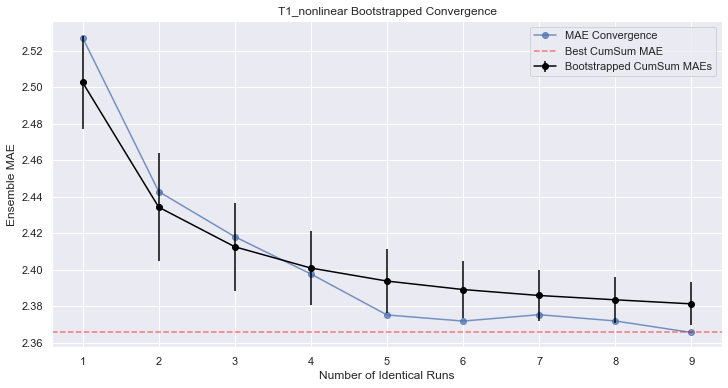

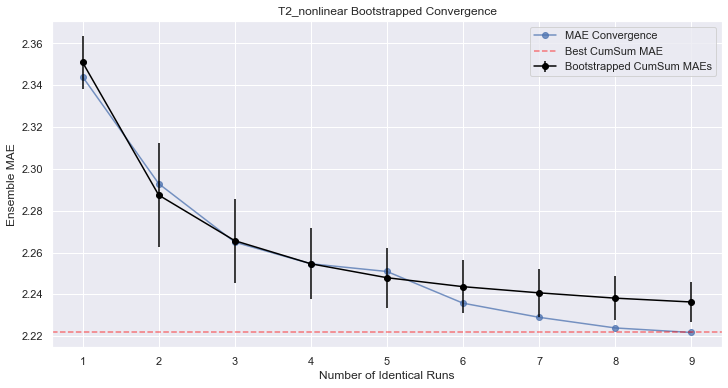

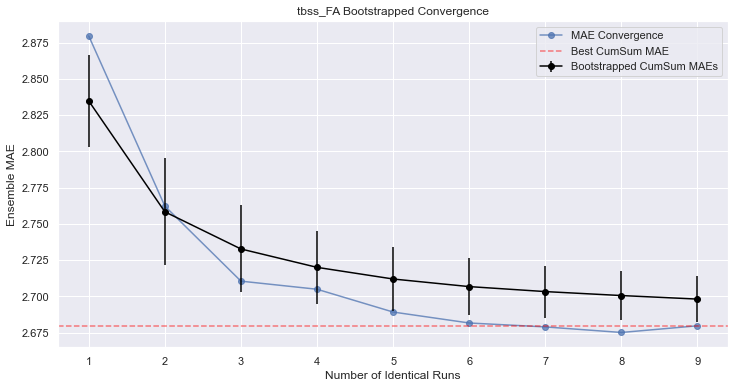

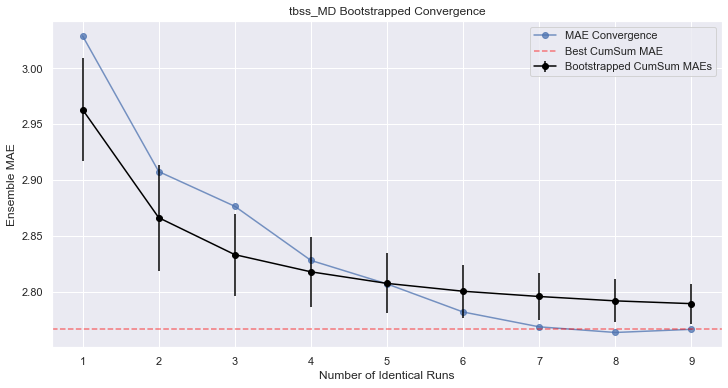

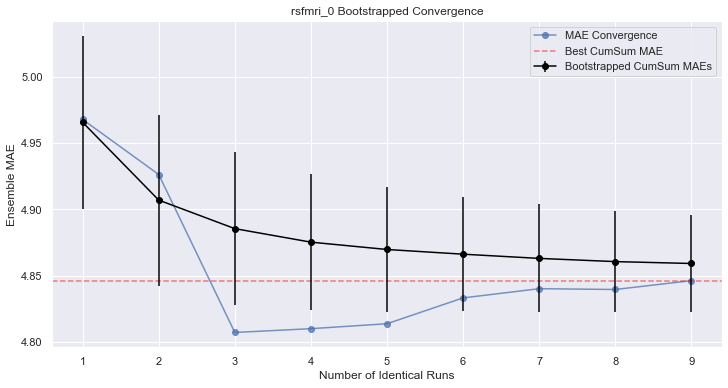

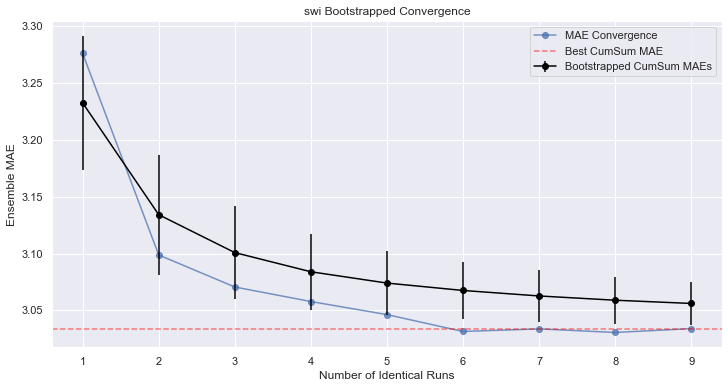

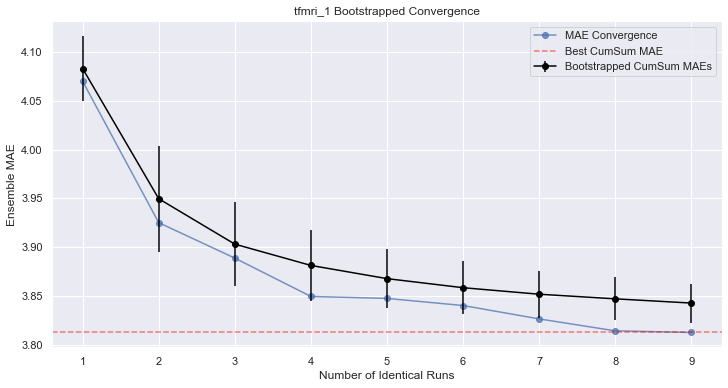

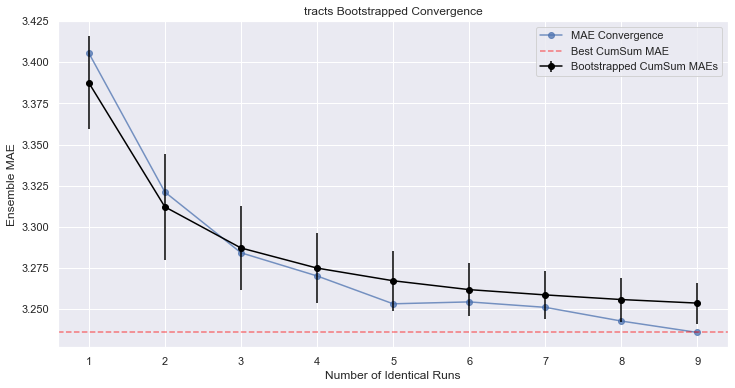

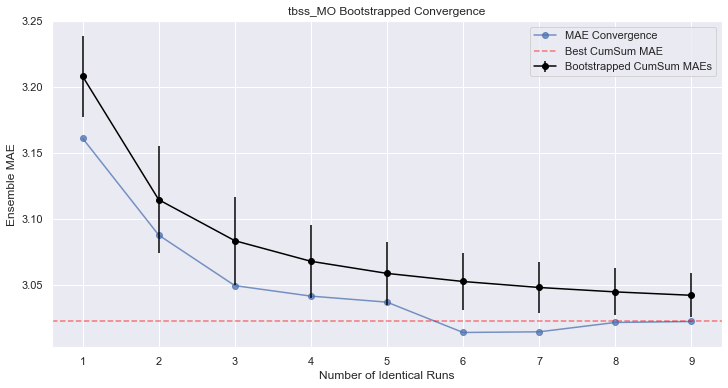

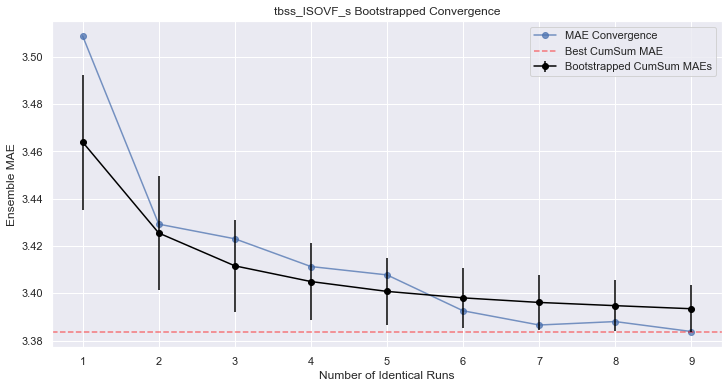

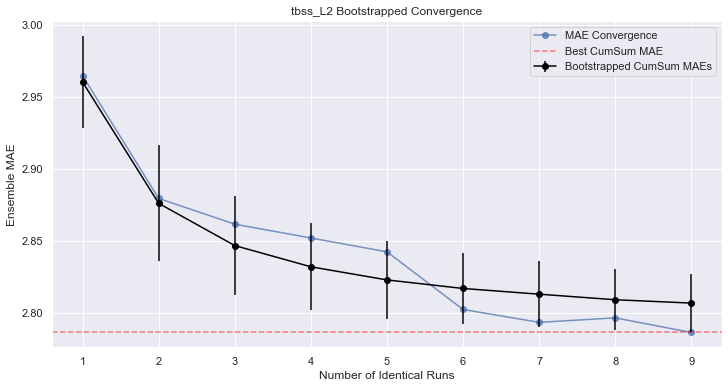

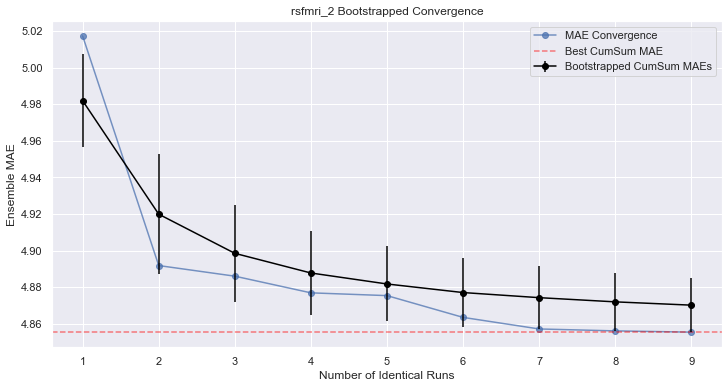

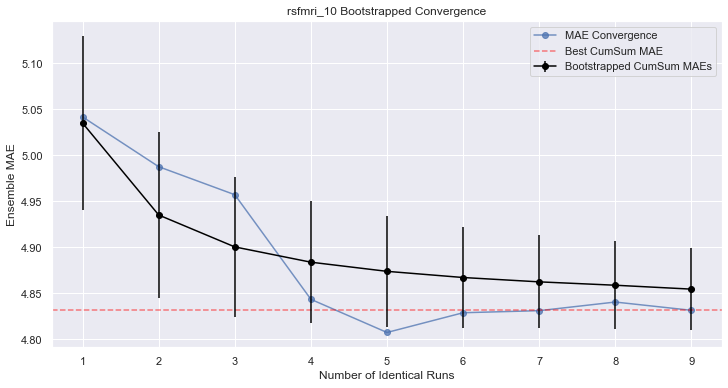

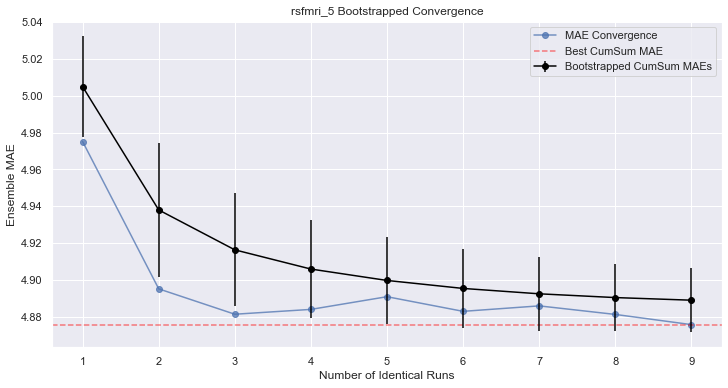

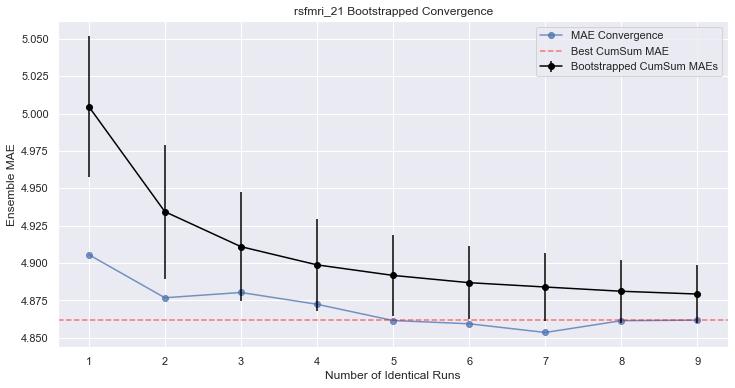

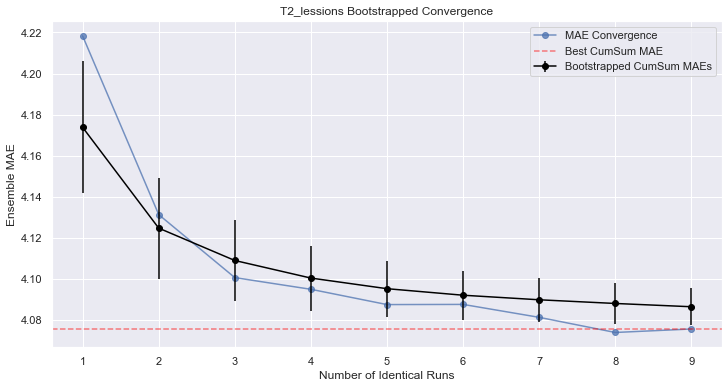

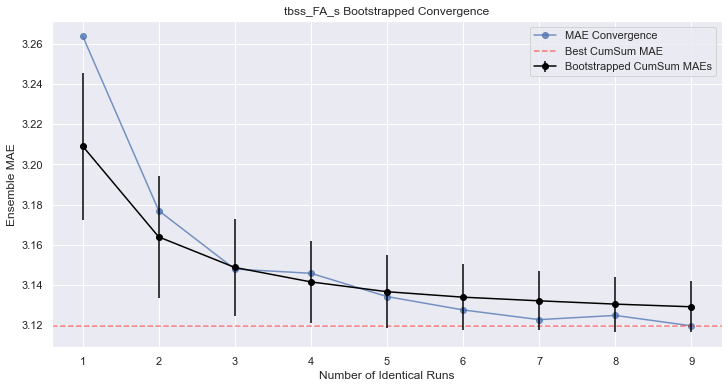

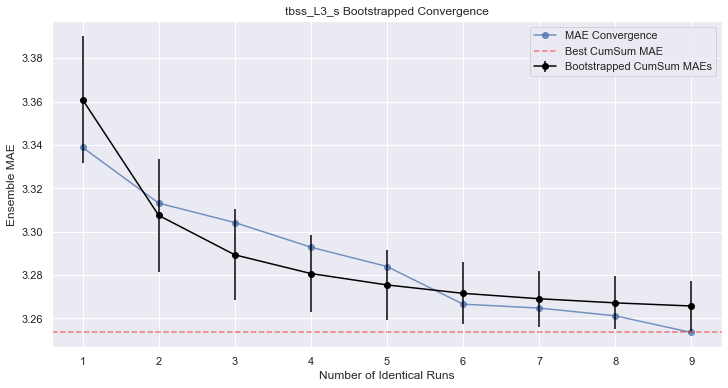

In [42]:
for i in range(len(dfs)):
    convergencePlots_short(dfs, i, names)

% Convergece MAEs
1 0.0
2 0.5220272800372923
3 0.6751206283617169
4 0.801589399664345
5 0.9405329025532359
6 0.9613246685118423
7 0.9396468309616764
8 0.9609271567430784
9 1.0
% Bootstrapped MAEs
1 0.0
2 0.5542013339191951
3 0.7452152923340699
4 0.8418211577202126
5 0.8968264052788228
6 0.9374664703030122
7 0.9637581205396506
8 0.9842122854484041
9 1.0
% Combined MAEs
1 0.0
2 0.5550384738828023
3 0.7426458035113985
4 0.8382390976840994
5 0.8960717660528279
6 0.9350351715763754
7 0.9627303383520939
8 0.9839774964236622
9 1.0


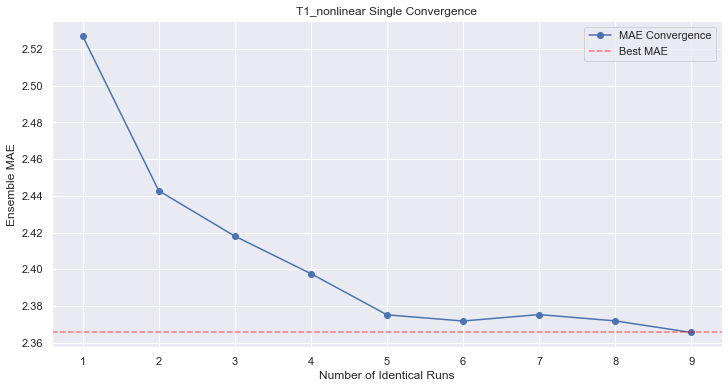

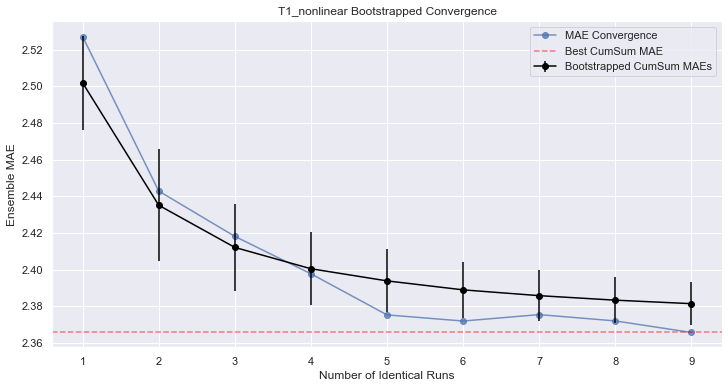

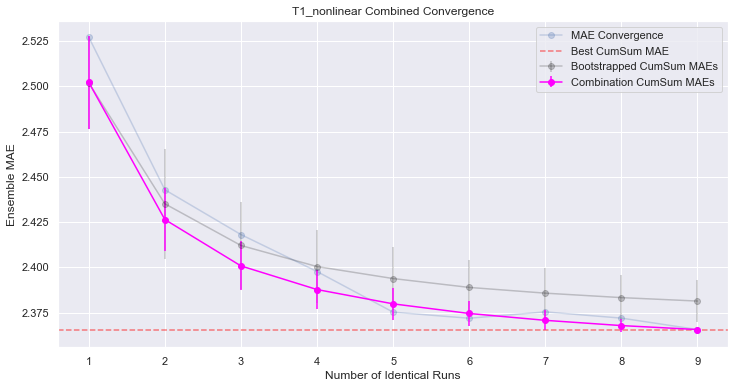

In [43]:
convergencePlots(dfs, 0, names)

% Convergece MAEs
1 0.0
2 0.34163405893796883
3 1.3215445072447027
4 1.2979756906375581
5 1.2672672709418837
6 1.10704662586725
7 1.049972744949135
8 1.0548532041832994
9 1.0
% Bootstrapped MAEs
1 0.0
2 0.550231053126621
3 0.7487500765317427
4 0.8399098989533027
5 0.8984752043506297
6 0.9307567981663649
7 0.9587943453844964
8 0.9857664301023671
9 1.0
% Combined MAEs
1 0.0
2 0.5590852200209686
3 0.7512691305420748
4 0.8469617657661878
5 0.9025168987620014
6 0.9394169438397371
7 0.9656712994394735
8 0.9848568411825167
9 1.0


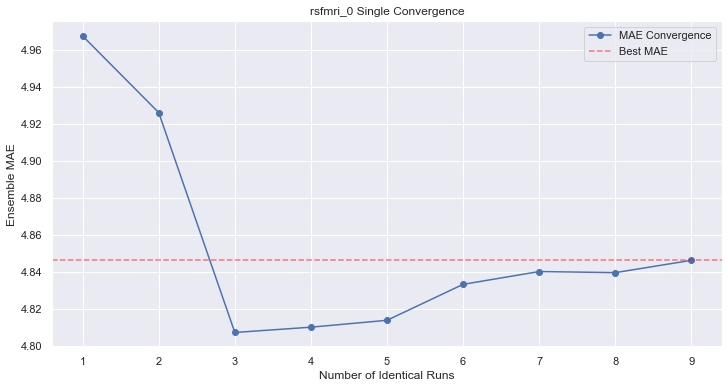

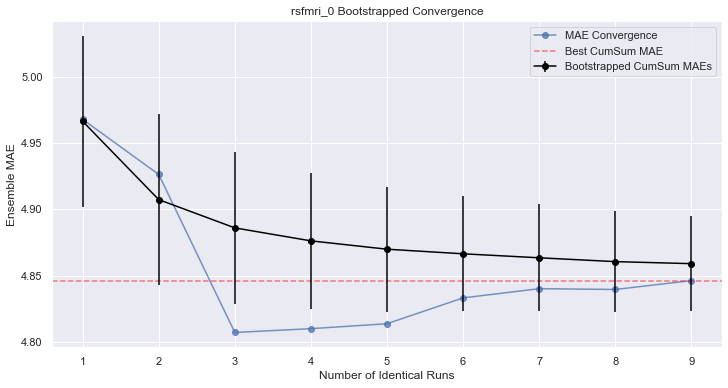

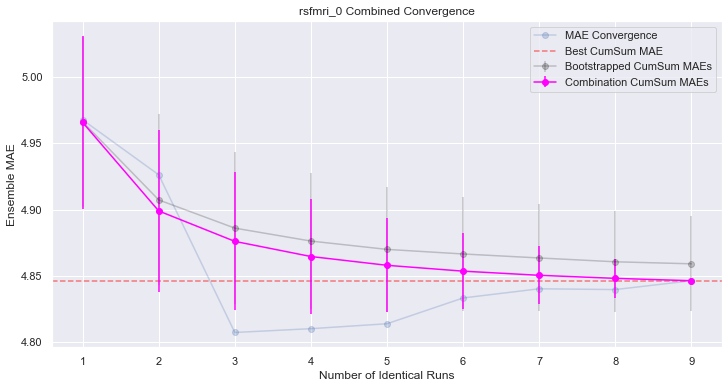

In [44]:
convergencePlots(dfs, 4, names)

% Convergece MAEs
1 0.0
2 0.4974264065878191
3 0.7148550216115865
4 0.7977297017656234
5 0.8974284316370449
6 0.8906220116945097
7 0.9101002393197645
8 0.9591827548448035
9 1.0
% Bootstrapped MAEs
1 0.0
2 0.5582536175248344
3 0.7444890161193207
4 0.8375730545050593
5 0.897529821361855
6 0.9354222477635573
7 0.9624314789118343
8 0.9832880647191298
9 1.0
% Combined MAEs
1 0.0
2 0.5561371453602248
3 0.742165173384056
4 0.8363110848814709
5 0.8941256225488547
6 0.9333338763331568
7 0.9617604513291121
8 0.9832138028143292
9 1.0


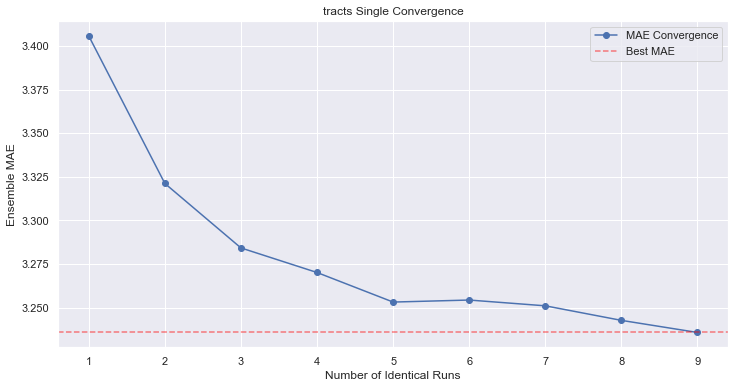

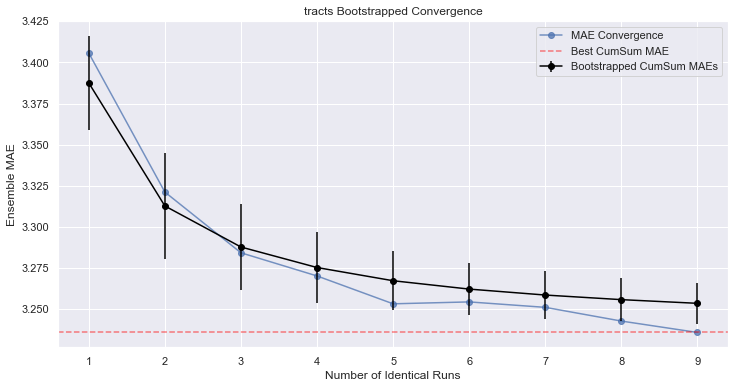

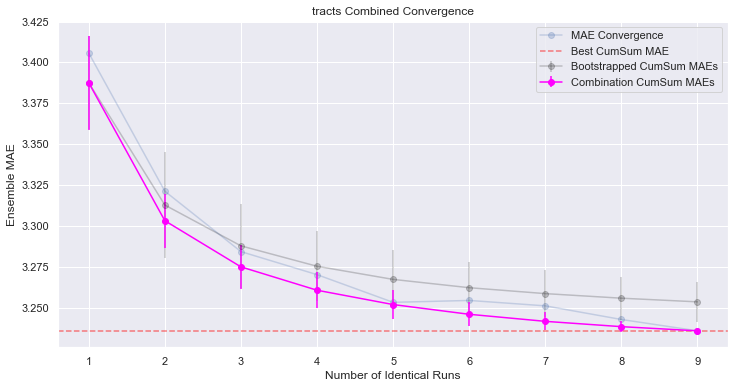

In [45]:
convergencePlots(dfs, 7, names)

% Convergece MAEs
1 0.0
2 0.4622242738941005
3 0.580589936293346
4 0.7650071657406119
5 0.8451197816302354
6 0.940872410123839
7 0.9914326900233263
8 1.0106774674521177
9 1.0
% Bootstrapped MAEs
1 0.0
2 0.5587825561595338
3 0.7465414651877098
4 0.8374680759072095
5 0.8969616026773526
6 0.9341232574279946
7 0.9626246001640221
8 0.982587498028198
9 1.0
% Combined MAEs
1 0.0
2 0.5521431469887907
3 0.7399532315371022
4 0.8362371984985993
5 0.8946129482426645
6 0.933749718513774
7 0.9619104928207173
8 0.9833252825688021
9 1.0


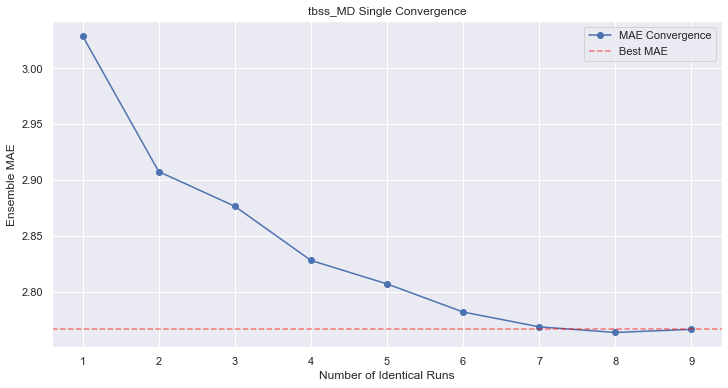

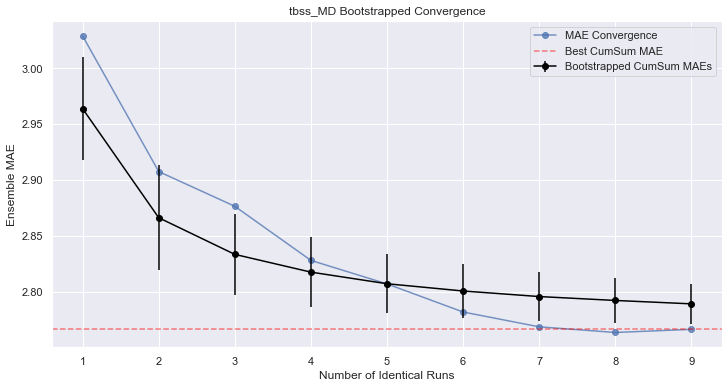

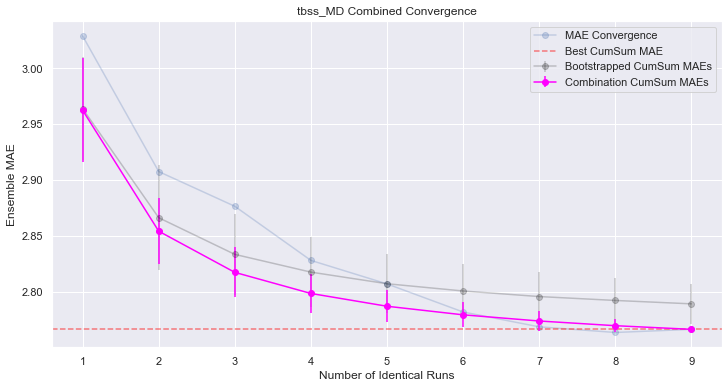

In [46]:
convergencePlots(dfs, 3, names)

% Convergece MAEs
1 0.0
2 0.6097239175442281
3 0.824646086599303
4 0.8645458110038493
5 0.9166859296971168
6 0.9161162795351192
7 0.9602389600501889
8 1.0118840091483652
9 1.0
% Bootstrapped MAEs
1 0.0
2 0.5564676782173963
3 0.745308142631979
4 0.8410083889839824
5 0.899342808543117
6 0.9366617654128327
7 0.9672295536020009
8 0.9837803768267672
9 1.0
% Combined MAEs
1 0.0
2 0.5548206149620418
3 0.7465666732233998
4 0.8423649321748292
5 0.8995554383087982
6 0.9371969715432414
7 0.9634795695542342
8 0.9836524555006239
9 1.0


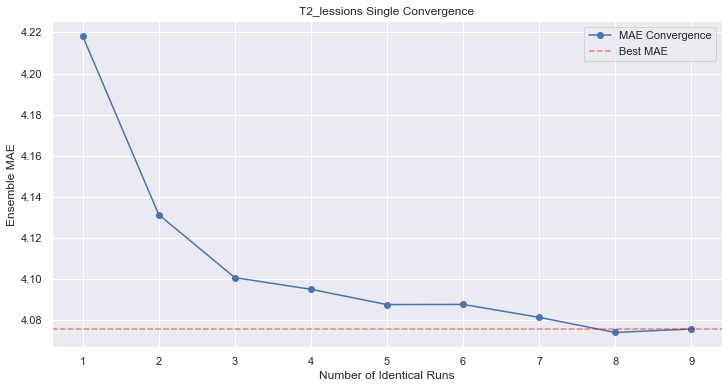

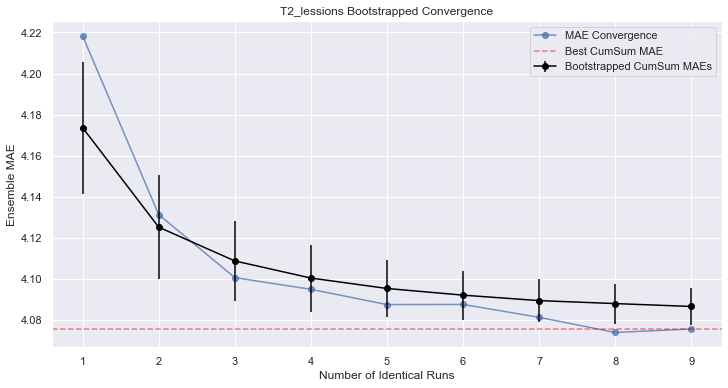

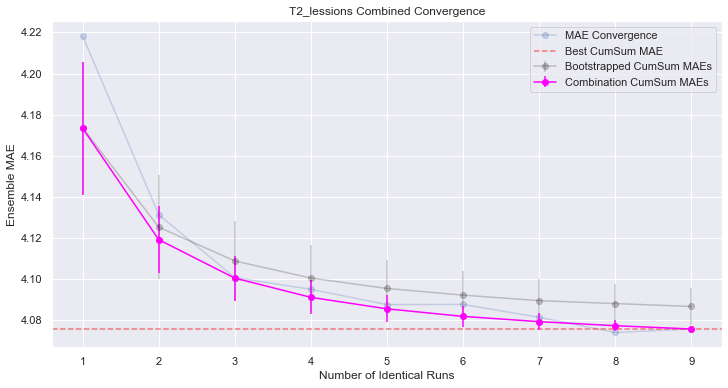

In [47]:
convergencePlots(dfs, 15, names)

% Convergece MAEs
1 0.0
2 0.30106246437890016
3 0.4057606469018128
4 0.539030533141732
5 0.6433821362592189
6 0.8469832196151734
7 0.8680753367312767
8 0.909872068283108
9 1.0
% Bootstrapped MAEs
1 0.0
2 0.558230015388955
3 0.7443198147129446
4 0.8450021893222333
5 0.8980936889738859
6 0.9382339503800218
7 0.9598425129129312
8 0.9837520261429149
9 1.0
% Combined MAEs
1 0.0
2 0.5587172098049265
3 0.7463372887918805
4 0.8404007601053707
5 0.8972407433766315
6 0.9355980223912713
7 0.9627039521271096
8 0.9841465121259977
9 1.0


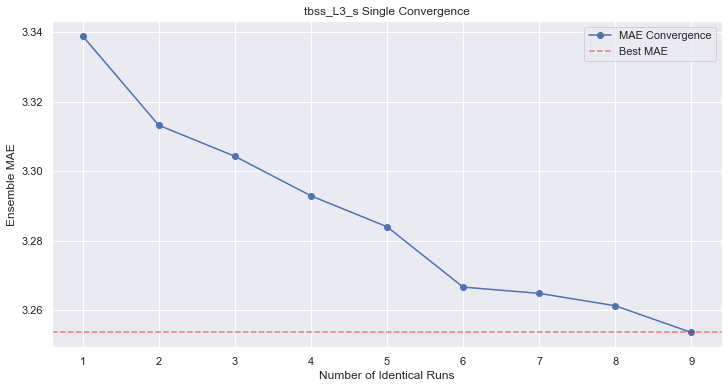

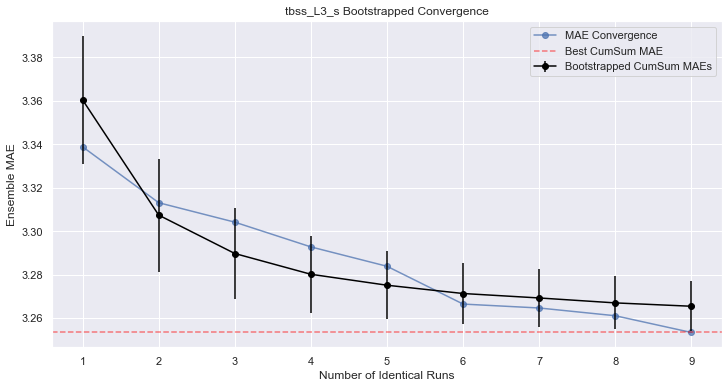

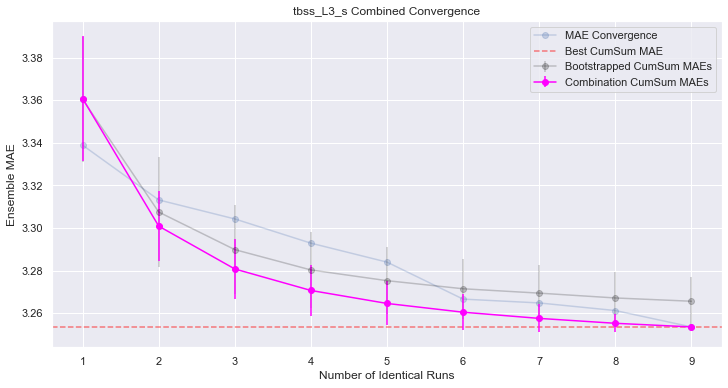

In [48]:
convergencePlots(dfs, 17, names)

In [49]:

net1 = "1" # T1NL
net2 = '2' # T2NL
net3 = '3' # FA
net4 = "4" # MD
net5 = '8' # rsfMRI 0
net6 = '9' # SWI
net7 = "10" # tfMRI 1
net8 = '12' # dmri tracts
net9 = '14' # MO
net10 = "6" # TBSS ISOVF
net11 = '15' # L2
net12 = '7' # rsfMRI 2
net13 = "16" # rsfMRI 10
net14 = '17' # rsfMRI 5
net15 = '18' # rsfMRI 21
net16 = "13" # T2 Lessions
net17 = '5' # TBSS FA
net18 = '19' # TBSS L3

# net19 = '11' # tfMRI 5

dfs = [
    net1,
    net2,
    net3,
    net4,
    net5,
    net6,
    net7,
    net8,
    net9,
    net10,
    net11,
    net12,
    net13,
    net14,
    net15,
    net16,
    net17,
    net18,
#     net19
]

names = [

    'T1_nonlinear',           #1
    'T2_nonlinear',           #2
    'tbss_FA',                #3
    'tbss_MD',                #4
    'rsfmri_0',               #5
    'swi',                    #6
    'tfmri_1',                #7
    'tracts',                 #8
    'tbss_MO',                #9
    'tbss_ISOVF_s',           #10
    'tbss_L2',                #11
    'rsfmri_2',               #12
    'rsfmri_10',              #13
    'rsfmri_5',               #14
    'rsfmri_21',              #15
    'T2_lessions',            #16
    'tbss_FA_s',              #17
    'tbss_L3_s',              #18
#     'tfmri_5',                #19
    
]
    
    
dfs1, dfs2, dfs3 = [], [], []
dfs4, dfs5, dfs6 = [], [], []
dfs7, dfs8, dfs9 = [], [], []

dfs1 = dfs.copy()
dfs2 = dfs.copy()
dfs3 = dfs.copy()
dfs4 = dfs.copy()
dfs5 = dfs.copy()
dfs6 = dfs.copy()
dfs7 = dfs.copy()
dfs8 = dfs.copy()
dfs9 = dfs.copy()


for idx in range(len(dfs)):
    
    dfs1[idx] = '../predictions/SN1-' + dfs1[idx] + '_predictions/output_statistics_test.csv'
    dfs2[idx] = '../predictions/SN2-' + dfs2[idx] + '_predictions/output_statistics_test.csv'
    dfs3[idx] = '../predictions/SN3-' + dfs3[idx] + '_predictions/output_statistics_test.csv'
    dfs4[idx] = '../predictions/SN4-' + dfs4[idx] + '_predictions/output_statistics_test.csv'
    dfs5[idx] = '../predictions/SN5-' + dfs5[idx] + '_predictions/output_statistics_test.csv'
    dfs6[idx] = '../predictions/SN6-' + dfs6[idx] + '_predictions/output_statistics_test.csv'
    dfs7[idx] = '../predictions/SN7-' + dfs7[idx] + '_predictions/output_statistics_test.csv'
    dfs8[idx] = '../predictions/SN8-' + dfs8[idx] + '_predictions/output_statistics_test.csv'
    dfs9[idx] = '../predictions/SN9-' + dfs9[idx] + '_predictions/output_statistics_test.csv'

    
for idx in range(len(dfs)):
    dfs1[idx] = pd.read_csv(dfs1[idx])
    dfs2[idx] = pd.read_csv(dfs2[idx])
    dfs3[idx] = pd.read_csv(dfs3[idx])
    dfs4[idx] = pd.read_csv(dfs4[idx])
    dfs5[idx] = pd.read_csv(dfs5[idx])
    dfs6[idx] = pd.read_csv(dfs6[idx])
    dfs7[idx] = pd.read_csv(dfs7[idx])
    dfs8[idx] = pd.read_csv(dfs8[idx])
    dfs9[idx] = pd.read_csv(dfs9[idx])

    
for idx in range(len(dfs)):
    dfs[idx] = pd.merge(dfs1[idx], dfs2[idx], on='Unnamed: 0', how='inner')
    dfs[idx] = pd.merge(dfs[idx], dfs3[idx], on='Unnamed: 0', how='inner')
    
    dfs[idx].rename({
        'target_age_x': 'target_age_original',
        'output_age_x': 'output_age_1',
        'age_delta_x': 'age_delta_1',
        'loss_x': 'loss_1',
        'target_age_y': 'target_age_2',
        'output_age_y': 'output_age_2',
        'age_delta_y': 'age_delta_2',
        'loss_y': 'loss_2',
        'target_age': 'target_age_3',
        'output_age': 'output_age_3',
        'age_delta': 'age_delta_3',
        'loss': 'loss_3',
    }, axis=1, inplace=True)
    
    dfs[idx].drop(['target_age_2', 'target_age_3'], axis=1, inplace=True)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs4[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_4',
        'age_delta': 'age_delta_4',
        'loss': 'loss_4',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs5[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_5',
        'age_delta': 'age_delta_5',
        'loss': 'loss_5',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs6[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_6',
        'age_delta': 'age_delta_6',
        'loss': 'loss_6',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
      
    
    dfs[idx] = pd.merge(dfs[idx], dfs7[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_7',
        'age_delta': 'age_delta_7',
        'loss': 'loss_7',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs8[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_8',
        'age_delta': 'age_delta_8',
        'loss': 'loss_8',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs9[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_9',
        'age_delta': 'age_delta_9',
        'loss': 'loss_9',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    dfs[idx].rename({
        'target_age_original': 'target_age',
    }, axis=1, inplace=True)
    
    dfs[idx]['mean_output_age'] = dfs[idx][['output_age_1', 'output_age_2', 'output_age_3',
                                           'output_age_4', 'output_age_5', 'output_age_6',
                                           'output_age_7', 'output_age_8', 'output_age_9',
                                           ]].mean(axis=1)
    dfs[idx]['mean_age_delta'] = dfs[idx]['mean_output_age'] - dfs[idx]['target_age']
    
for idx in range(len(dfs)):    
    dfs[idx]['output_age_decon'] = age_debiasing(dfs[idx].mean_output_age, dfs[idx].target_age) 
    dfs[idx]['age_delta_decon'] = dfs[idx].output_age_decon - dfs[idx].target_age
    

d = {'modality':names, 'dataframe':dfs}
df = pd.DataFrame(data=d)
df.to_pickle('female_test_testAB_convergence9.pkl', protocol = 4)

In [50]:
df

,modality,dataframe
0,T1_nonlinear,Unnamed: 0 target_age output_age_1 ag...
1,T2_nonlinear,Unnamed: 0 target_age output_age_1 ag...
2,tbss_FA,Unnamed: 0 target_age output_age_1 ag...
3,tbss_MD,Unnamed: 0 target_age output_age_1 ag...
4,rsfmri_0,Unnamed: 0 target_age output_age_1 ag...
5,swi,Unnamed: 0 target_age output_age_1 ag...
6,tfmri_1,Unnamed: 0 target_age output_age_1 ag...
7,tracts,Unnamed: 0 target_age output_age_1 ag...
8,tbss_MO,Unnamed: 0 target_age output_age_1 ag...
9,tbss_ISOVF_s,Unnamed: 0 target_age output_age_1 ag...


In [51]:
df.iloc[1].dataframe

,Unnamed: 0,target_age,output_age_1,age_delta_1,loss_1,output_age_2,age_delta_2,loss_2,output_age_3,age_delta_3,...,output_age_8,age_delta_8,loss_8,output_age_9,age_delta_9,loss_9,mean_output_age,mean_age_delta,output_age_decon,age_delta_decon
0,24806531,67.670660,70.104294,2.433632,5.922564,68.086380,0.415718,0.172822,67.088300,-0.582359,...,69.234680,1.564018,2.446153,67.945694,0.275032,0.075643,68.540834,0.870174,69.149334,1.478674
1,24237795,77.280940,75.504140,-1.776794,3.156998,75.311966,-1.968971,3.876848,76.382620,-0.898315,...,74.907150,-2.373787,5.634864,75.579770,-1.701164,2.893960,75.312617,-1.968323,77.004576,-0.276364
2,24748274,58.301940,61.251984,2.950043,8.702752,60.295338,1.993397,3.973631,60.411247,2.109306,...,60.723780,2.421841,5.865312,62.881287,4.579346,20.970407,60.667449,2.365509,60.016236,1.714296
3,25463415,58.056694,59.470676,1.413982,1.999346,61.485233,3.428539,11.754882,61.635876,3.579182,...,61.584600,3.527904,12.446110,57.913948,-0.142746,0.020376,60.710397,2.653703,60.066056,2.009362
4,25313661,59.653084,59.016640,-0.636444,0.405061,58.125770,-1.527313,2.332686,55.715540,-3.937542,...,57.056202,-2.596882,6.743795,57.909440,-1.743645,3.040297,58.235239,-1.417845,57.194881,-2.458203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,25475074,59.848515,60.740215,0.891701,0.795130,62.015520,2.167004,4.695905,60.920270,1.071754,...,60.089237,0.240723,0.057947,62.364655,2.516140,6.330960,61.404594,1.556079,60.871321,1.022806
5016,22834218,60.501940,58.448810,-2.053131,4.215347,56.783882,-3.718059,13.823967,57.397167,-3.104774,...,57.998104,-2.503838,6.269203,56.962380,-3.539562,12.528501,57.450777,-3.051163,56.284909,-4.217031
5017,24442683,56.130707,51.730434,-4.400272,19.362396,52.082695,-4.048012,16.386400,51.744700,-4.386005,...,52.284527,-3.846180,14.793100,52.310966,-3.819740,14.590416,52.017357,-4.113350,49.982161,-6.148546
5018,21157566,78.016556,75.636280,-2.380279,5.665730,76.854890,-1.161667,1.349470,76.076485,-1.940071,...,77.351350,-0.665207,0.442500,75.241585,-2.774971,7.700464,76.215023,-1.801533,78.051363,0.034807


In [ ]:
# from scipy.stats import pearsonr

In [32]:
# pearsonr(df.iloc[0].dataframe.mean_age_delta, df.iloc[2].dataframe.mean_age_delta)

In [33]:
# df.iloc[0].dataframe.to_csv('female_test_testAB_convergence_T1.csv')
# df.iloc[1].dataframe.to_csv('female_test_testAB_convergence_T2.csv')
# df.iloc[2].dataframe.to_csv('female_test_testAB_convergence_FA.csv')

In [34]:
# df.iloc[0].dataframe[['Unnamed: 0', 'target_age', 'mean_output_age']].to_csv('female_test_testAB_convergence_T1.csv')
# df.iloc[1].dataframe[['Unnamed: 0', 'target_age', 'mean_output_age']].to_csv('female_test_testAB_convergence_T2.csv')
# df.iloc[2].dataframe[['Unnamed: 0', 'target_age', 'mean_output_age']].to_csv('female_test_testAB_convergence_FA.csv')

In [35]:
# df.iloc[0].dataframe[['Unnamed: 0', 'target_age', 'mean_output_age']]